# Machine Learning &mdash; Tutorial3
### Sarah Filippi

## Q1: Principal Component Analysis

Consider the US arrests dataset. This dataset contains statistics in arrests per 100,000 residents for assault, murder, and rape in each of the 50 US states in 1973. Also given is the percent of the population living in urban areas. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve, auc, silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cluster import KMeans

np.random.seed(12345)

We start by looking at the data with a pairplot.

In [6]:
df = pd.read_csv("USArrests.csv", index_col=0)

df.head()

,Murder,Assault,UrbanPop,Rape
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6



We start by looking at the data with a pairplot.


/Users/sarahfilippi/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


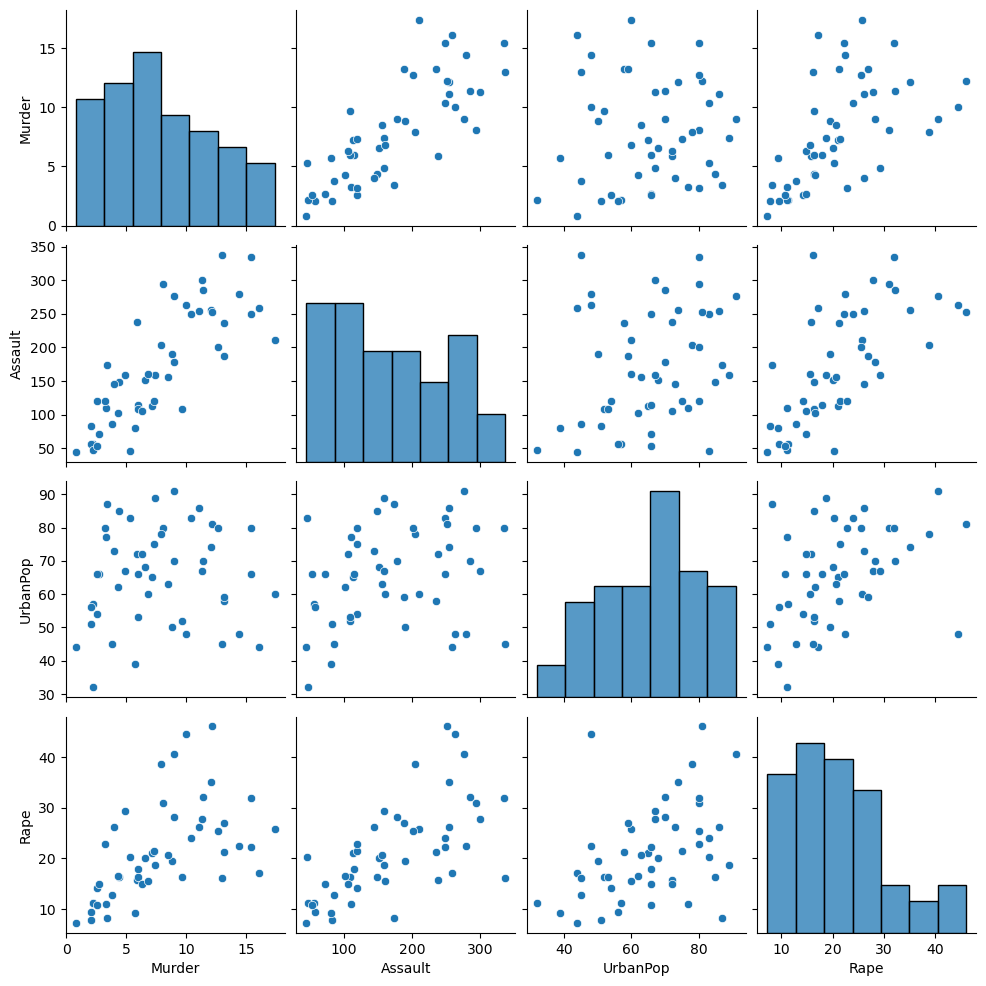

In [8]:
sns.pairplot(data=df)

## i)

We will first scale the data to have mean 0 and variance 1. The principal components are then the eigenvectors of $\mathbf{X}^T \mathbf{X}$.

In [11]:
scaled_df = (df - df.mean()) / df.std()
X = scaled_df.values
eigendecomp_XTX = np.linalg.eig(X.T @ X)
idx = np.argsort(eigendecomp_XTX[0])[::-1] # note unlike R, numpy does not automatically order by eignenvalue size
PCs = eigendecomp_XTX[1][:, idx]

[[ 0.53589947  0.41818087 -0.34123273  0.6492278 ]
 [ 0.58318363  0.1879856  -0.26814843 -0.74340748]
 [ 0.27819087 -0.87280619 -0.37801579  0.13387773]
 [ 0.54343209 -0.16731864  0.81777791  0.08902432]]


## ii)

The proportion of variance they explain are the corresponding eigenvalues.

In [12]:
var_explained = eigendecomp_XTX[0][idx]

Plotting the variance explained (bars indicate the percentage of variance explained by a PC and the line/point show the cumulative variance explained):

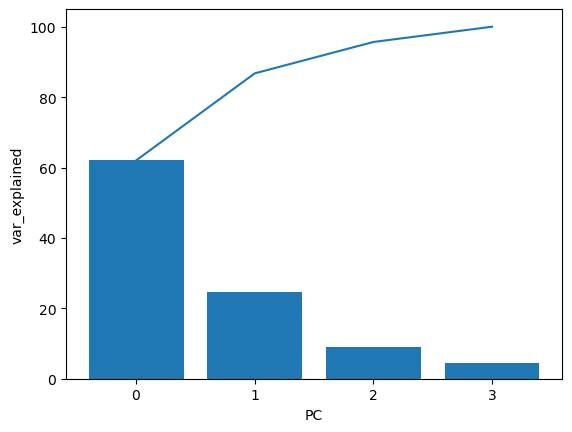

In [13]:
var_explained *= 100.0 / var_explained.sum()
plt.bar(x=range(len(var_explained)), height=var_explained)
plt.plot(np.cumsum(var_explained))
plt.xlabel("PC")
plt.ylabel("var_explained")
plt.xticks(range(len(var_explained)))
plt.show()

## iii) 

To rotate the data into the orthogonal basis found by PCA, we multiply $\mathbf{X}$ by the principal components:

In [14]:
rot_X = X @ PCs

We can then select the first two PCs and plot them:

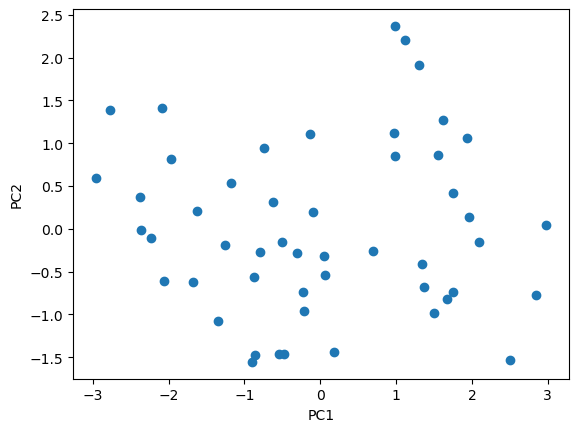

In [15]:
plt.scatter(rot_X[:, 0], rot_X[:, 1])
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

# Q2: PCA on the MNIST dataset

Load and preprocess MNIST data.

In [16]:
# read in the dataset
mnist = pd.read_csv("../Tutorial2/mnist.csv", header=None)
mnist = mnist.to_numpy()

# split into X and y
X = mnist[:, 1:]
y = mnist[:, 0]

# keep 4s and 9s only - 12,665 examples in total
included_examples = np.isin(y, [4, 9])
X = X[included_examples]
y = y[included_examples]

# convert to [0,1] from grayscale
X = X / 255.0

# remove zero-variance pixels - store them for use in the reconstruction later
zero_var_colidx = np.where(np.var(X, axis=0) == 0.0)
#stopifnot(all(X[,zero_var_colnames]==0)) # pixels have zero-variance because
                                           # they are exactly zero for all examples

# create transformed X
idx = np.setdiff1d(range(X.shape[1]), zero_var_colidx)
X_ = X[:, idx]
X_ = (X_ - X_.mean(0)) / X_.std(0)

## a) PCA

Now we perform PCA.

In [17]:
prcomp = PCA()
pca_out = prcomp.fit(X_)

The scree plot shows that the first 100 PCs account for about 80% of the variance in the dataset. Since we have many more PCs than in the previous question we put the explained variance and cumulative explained variance on separate plots.

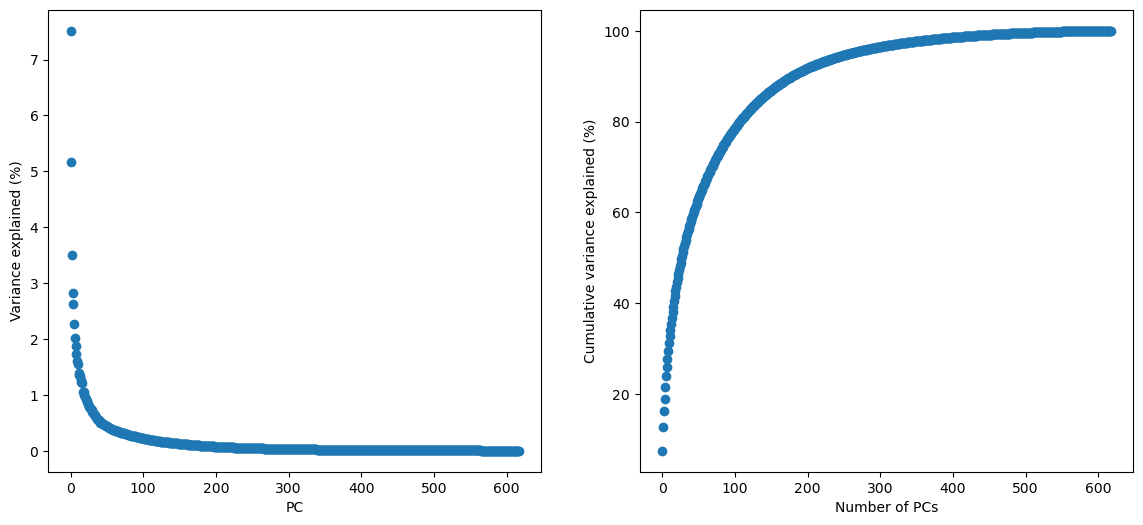

In [18]:
var_explained = pca_out.explained_variance_
var_explained *= 100.0 / var_explained.sum()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

ax[0].scatter(range(pca_out.n_components_), var_explained)
ax[0].set_xlabel("PC")
ax[0].set_ylabel("Variance explained (%)") 

ax[1].scatter(range(pca_out.n_components_), np.cumsum(var_explained))
ax[1].set_xlabel("Number of PCs")
ax[1].set_ylabel("Cumulative variance explained (%)") 

plt.show()

## b)

Given a matrix of principal components $\mathbf{V}$, the reconstruction is given by $\hat{\mathbf{X}} = \mathbf{X} \mathbf{V} \mathbf{V}^T$, provided we are working with zero-mean columns.

In [19]:
V = pca_out.components_.T

# reconstruct X using different numbers of PCs
k_list = [10, 200, 500]
X_recon = list(map(lambda k: X_ @ V[:, :k] @ V[:, :k].T, k_list))
X_recon = dict(zip(k_list, X_recon))

# Add the zero columns
zeros = np.zeros((X_.shape[0], len(zero_var_colidx[0])))
nonzero_var_colidx = np.setdiff1d(range(X.shape[1]), zero_var_colidx)

# need to reorder the columns so that the zeros are in the correct place
def recon(x):
    x_recon = np.concatenate([np.zeros_like(x), zeros], axis=1)
    x_recon[:, nonzero_var_colidx] = x
    return x_recon  
  
X_recon = dict(map(lambda x: (x[0], recon(x[1])), X_recon.items()))

Now we plot the original image alongside the reconstructions. We can see that the reconstructions get better the more PCs we use.

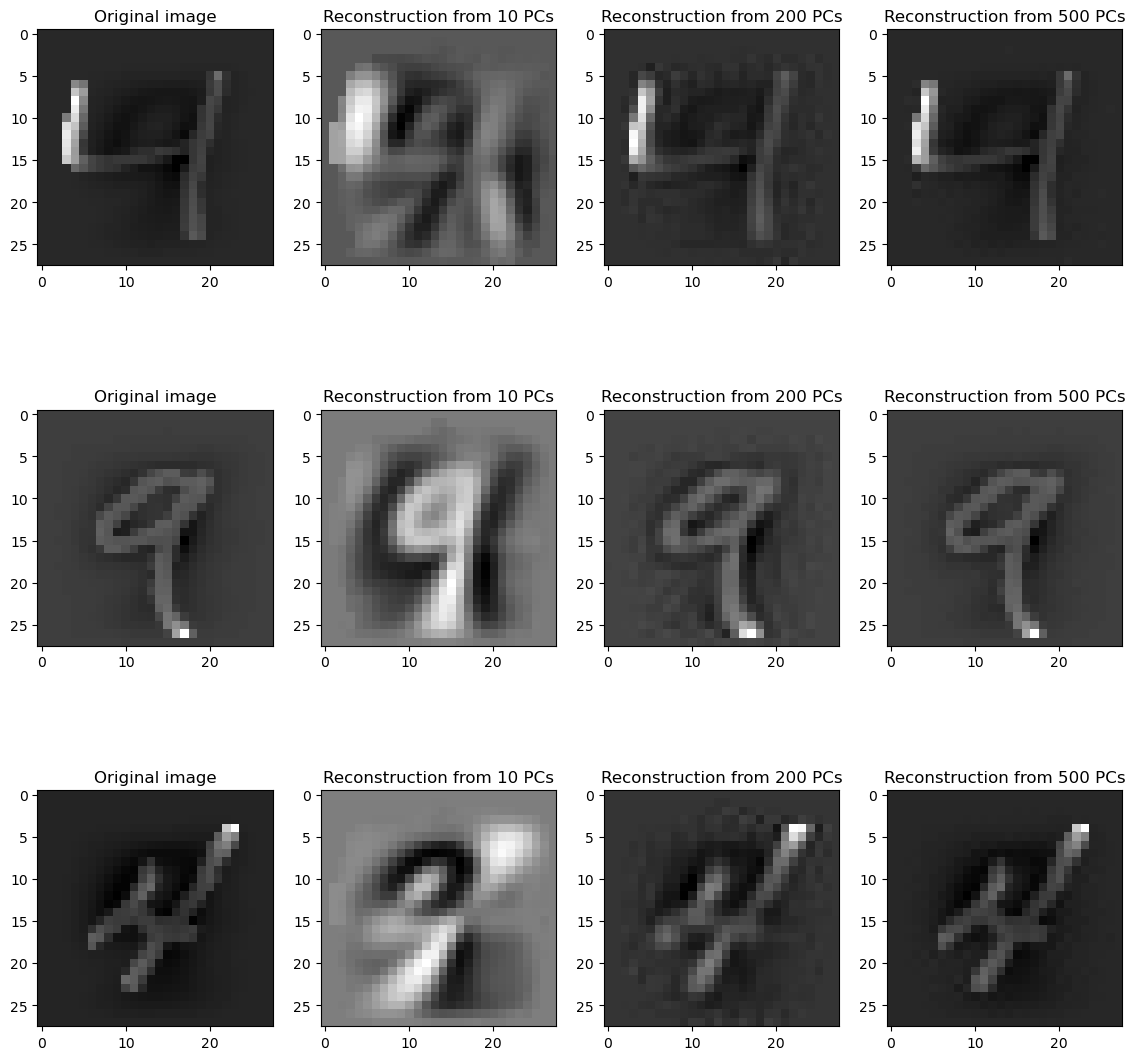

In [20]:
# also need to add the missing pixels to X_
X_transformed = recon(X_)

# visualise original image and reconstruction
def make_square(vec):
    image_size = int(np.sqrt(len(vec)))
    tmp = np.reshape(vec, (image_size, image_size))
    return tmp

fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(14, 14))
for i in range(3):
    ax[i, 0].imshow(make_square(X_transformed[i]), cmap='gray')
    ax[i, 0].set_title("Original image")
    j = 1
    for k, x in X_recon.items():
        ax[i, j].imshow(make_square(x[i]), cmap='gray')
        ax[i, j].set_title(f"Reconstruction from {k} PCs")
        j += 1
plt.show()

## c)

We can perform dimensionality reduction by only including a subset of the columns of $\mathbf{V}$ when calculating $\hat{\mathbf{X}} = \mathbf{X} \mathbf{V} \mathbf{V}^T$.

We use the element-wise sum-of-squares to measure the reconstruction error and measure the error to the transformed X (which has columns with zero mean and unit variance).

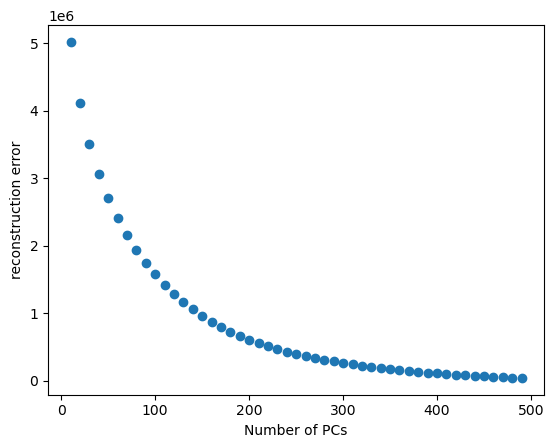

In [21]:
def recon_error(X1, X2):
    return np.sum((X1-X2)**2)

errors = list(map(lambda k: recon_error(X_, X_ @ V[:, :k] @ V[:, :k].T), np.arange(10, 500, step=10)))
plt.scatter(np.arange(10, 500, step=10), errors)
plt.xlabel("Number of PCs")
plt.ylabel("reconstruction error")
plt.show()              

The error decreases as more principal components are included, and is zero when all the columns of $\mathbf{V}$ are included as $\mathbf{V} \mathbf{V}^T = \mathbf{I}$.

## d) 

We start by splitting the data:

In [22]:
TEST_SIZE = 0.4 # put more data in test set to reduce computation time

# train/test split
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X_, y, np.arange(X_.shape[0]), test_size=TEST_SIZE)

Then we train a ridge classifier on the original variables. The L2-penalty strength is selected using 5-fold cross-validation.

In [23]:
# train ridge model on original variables

lmbdas = np.exp(np.linspace(-8, -2, 10))
Cs = 2/X_train.shape[0] * 1/lmbdas # for consistency with R implementation
ridge_raw = LogisticRegressionCV(Cs=Cs, cv=5, scoring='accuracy', penalty='l2', solver='lbfgs', max_iter=10000, tol=1.e-7)
ridge_raw.fit(X_train, y_train)

LogisticRegressionCV(Cs=array([0.84279276, 0.43270423, 0.22215776, 0.1140596 , 0.05856015,
       0.03006578, 0.01543629, 0.00792525, 0.00406896, 0.00208907]),
                     cv=5, max_iter=10000, scoring='accuracy', tol=1e-07)

/var/folders/m1/hb78ycdj61nb3xz0_0mn7_2h0000gn/T/ipykernel_86499/2627117040.py:3: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(x=np.linspace(-8, -2, 10),


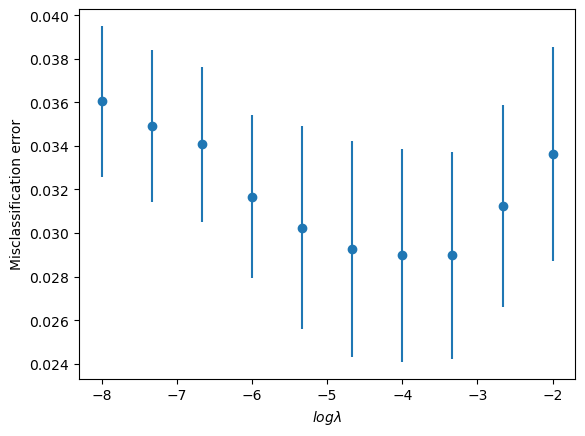

In [24]:
ridge_raw_scores = ridge_raw.scores_[9]

plt.errorbar(x=np.linspace(-8, -2, 10), 
             y=1 - ridge_raw_scores.mean(0), 
             yerr=ridge_raw_scores.std(0), 
             linestyle='none', fmt='-o')
plt.xlabel("$log \lambda$")
plt.ylabel("Misclassification error")
plt.show()

Then we train a ridge classifier on the first 20 PCs The L2-penalty strength is selected using 5-fold cross-validation.

In [25]:
# split rotated data
X_rot = pca_out.transform(X_)
X_rot = (X_rot - X_rot.mean(0)) / X_rot.std(0)
X_rot_train = X_rot[idx_train, :]
X_rot_test = X_rot[idx_test, :]

# train ridge model on first 20 PCs
lmbdas = np.exp(np.linspace(-10, -3, 10))
Cs = 2/X_train.shape[0] * 1/lmbdas
ridge_rot = LogisticRegressionCV(Cs=Cs, cv=5, scoring='accuracy', penalty='l2', solver='lbfgs', max_iter=10000, tol=1.e-7)
ridge_rot.fit(X_rot_train[:, :20], y_train)

LogisticRegressionCV(Cs=array([6.22744297e+00, 2.86104812e+00, 1.31443939e+00, 6.03887400e-01,
       2.77441466e-01, 1.27463774e-01, 5.85601495e-02, 2.69040450e-02,
       1.23604130e-02, 5.67869294e-03]),
                     cv=5, max_iter=10000, scoring='accuracy', tol=1e-07)

/var/folders/m1/hb78ycdj61nb3xz0_0mn7_2h0000gn/T/ipykernel_86499/629546230.py:3: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-o" (-> linestyle='-'). The keyword argument will take precedence.
  plt.errorbar(x=np.linspace(-10, -3, 10),


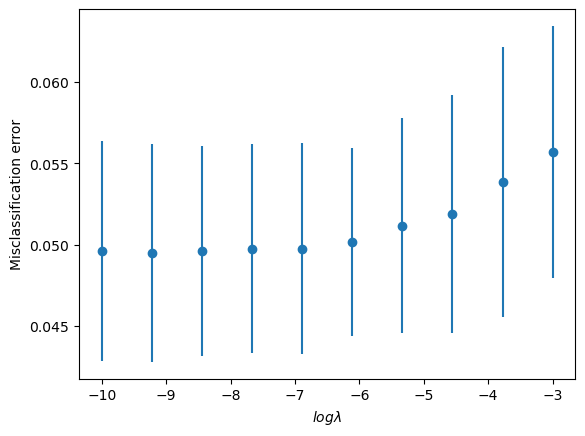

In [26]:
ridge_rot_scores = ridge_rot.scores_[9]

plt.errorbar(x=np.linspace(-10, -3, 10), 
             y=1 - ridge_rot_scores.mean(0), 
             yerr=ridge_rot_scores.std(0), 
             linestyle='none', fmt='-o')
plt.xlabel("$log \lambda$")
plt.ylabel("Misclassification error")
plt.show()

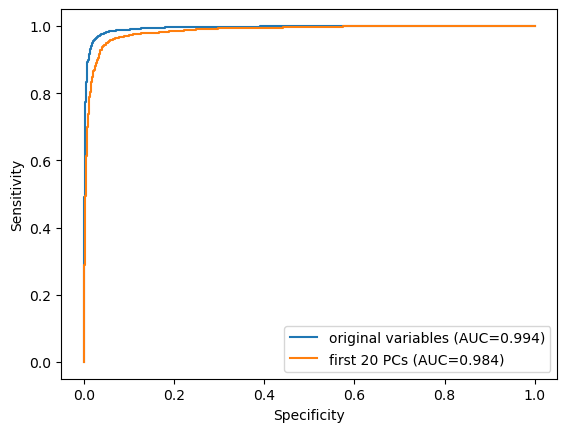

In [27]:
# test predictions for each model
yhat_test_raw = ridge_raw.predict_proba(X_test)
yhat_test_rot = ridge_rot.predict_proba(X_rot_test[:, :20])

raw_roc = roc_curve(y_test, yhat_test_raw[:, 1], pos_label=9)
rot_roc = roc_curve(y_test, yhat_test_rot[:, 1], pos_label=9)

auc_raw = auc(raw_roc[0], raw_roc[1])
auc_rot = auc(rot_roc[0], rot_roc[1])

# ROC curves
plt.plot(raw_roc[0], raw_roc[1], label=f"original variables (AUC={auc_raw:.3f})")
plt.plot(rot_roc[0], rot_roc[1], label=f"first 20 PCs (AUC={auc_rot:.3f})")
plt.xlabel("Specificity")
plt.ylabel("Sensitivity")
plt.legend()
plt.show()

We obtain a larger AUC using the 618 original variables, although the difference in AUC is 0.01 when using 20 PCs.

A model trained on the original variables is more interpretable than one trained on principal components. However, using principal components allows dimensionality reduction which can reduce the overall computational cost (when the cost of fitting the model is significantly greater than the cost of PCA) and can also remove some noise.

# Q3: K-means clustering

The SKlearn package offers a convenient way to calculate a large number of clustering indices. Here we will focus on the silhouette index, described in the following paper by Peter Rousseeuw: https://www.sciencedirect.com/science/article/pii/0377042787901257

The `n_init` parameter in the `KMeans` method in sklearn is the number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of `n_init` consecutive runs in terms of inertia. Inertia, or the within-cluster sum of squares criterion, is a measure of how internally coherent clusters are. 


In the example below, the k-means algorithm will be run 10 times with different initial centroids, and the best result in terms of inertia will be chosen. 

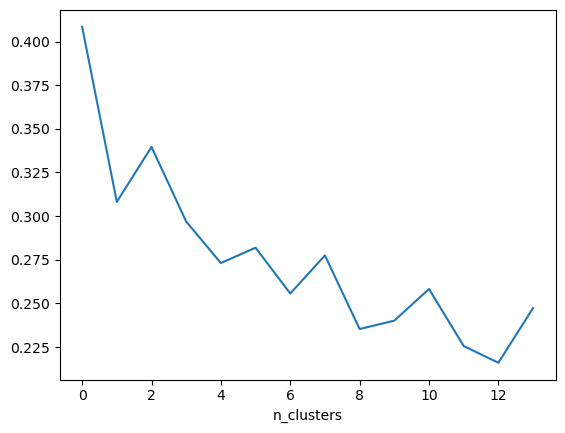

In [30]:
X = scaled_df

def nbc(n_clusters):
    km = KMeans(n_clusters=n_clusters, n_init=10)
    cluster_labels = km.fit_predict(X)
    return silhouette_score(X, cluster_labels)

n_clusters = np.arange(2, 16)

silhouettes = []
for n in n_clusters:
    silhouettes.append(nbc(n))


plt.plot(silhouettes)
plt.xlabel("n_clusters")
plt.show()

Using 2 clusters maximises  the silhouette indices, so that is our final choice.

Now we plot the data in the rotated space, colouring the points by their cluster assignment.

/Users/sarahfilippi/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


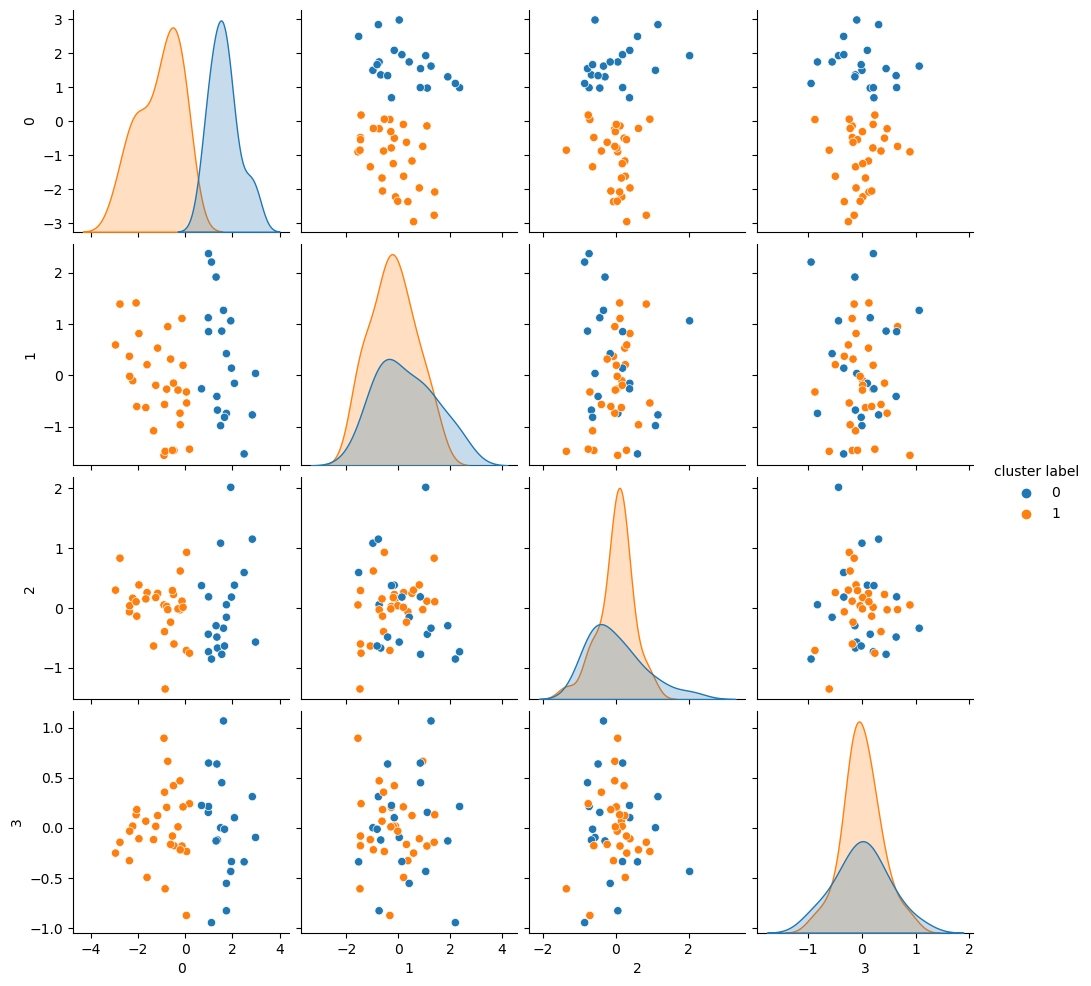

In [32]:
km = KMeans(n_clusters=2, n_init=10)
km.fit(X)

pca = PCA()
pca.fit(X)

df = pd.DataFrame(pca.transform(X))
df["cluster label"] = km.predict(X)

sns.pairplot(df, hue="cluster label")
plt.show()

# Q4: Hierarchical clustering

## a)

The three choices we make in heirarchichal clustering are
* the distance metric
* the linkage criterion
* the cut heigthplot

Let's use the Euclidian distance and compute a distance matrix as follows.

In [33]:
from scipy.spatial.distance import pdist, squareform

In [34]:
dist_data = pd.DataFrame(squareform(pdist(X)), index=X.index, columns=X.index)

We can then perform hierarchical clustering using the complete linkage criteria and plot the resulting dendogram. Complete linkage measures the proximity between two clusters using their farthest neighbour.


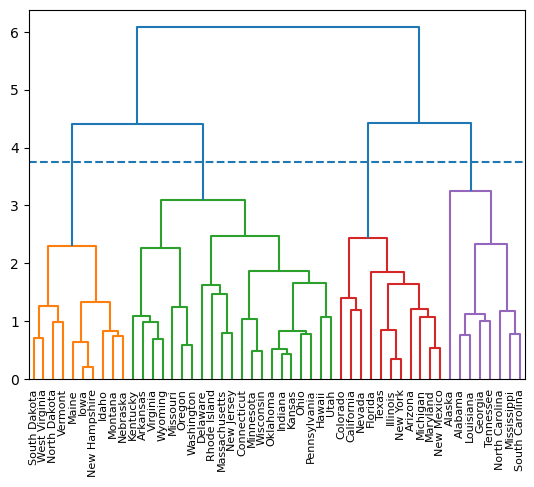

In [35]:
from scipy.cluster.hierarchy import linkage, dendrogram
hdata = linkage(X, method="complete")
dendrogram(hdata, labels=X.index)
plt.hlines(y=3.75, xmin=0, xmax=600, linestyle='dashed')
plt.show()

We can obtain the cluster allocation for each observation when cutting the dendogram at a given height using the following command:

In [36]:
from scipy.cluster.hierarchy import cut_tree
alloc = cut_tree(hdata, height=3.75)

A height of 3.75 leads to 4 clusters. The choice of cut height is often done "by-eye" following visual inspection of the dendrogam branch lengths (although we can also use the indices from the previous question).

## b)

The code below performs hierarchichal clustering for all combinations of complete, single and average linkage with Euclidean and Manhattan distance.

This shows the strong effect of the choice of linkage method - using `"complete"` or `"average"` linkage suggests that there are two primary clusters of approximately equal size. Using `"single"` linkage also suggests that there are two clusters but one of those clusters only contains a single state (Alaska). The choice of distance has a smaller effect on the final dendrograms for this dataset.

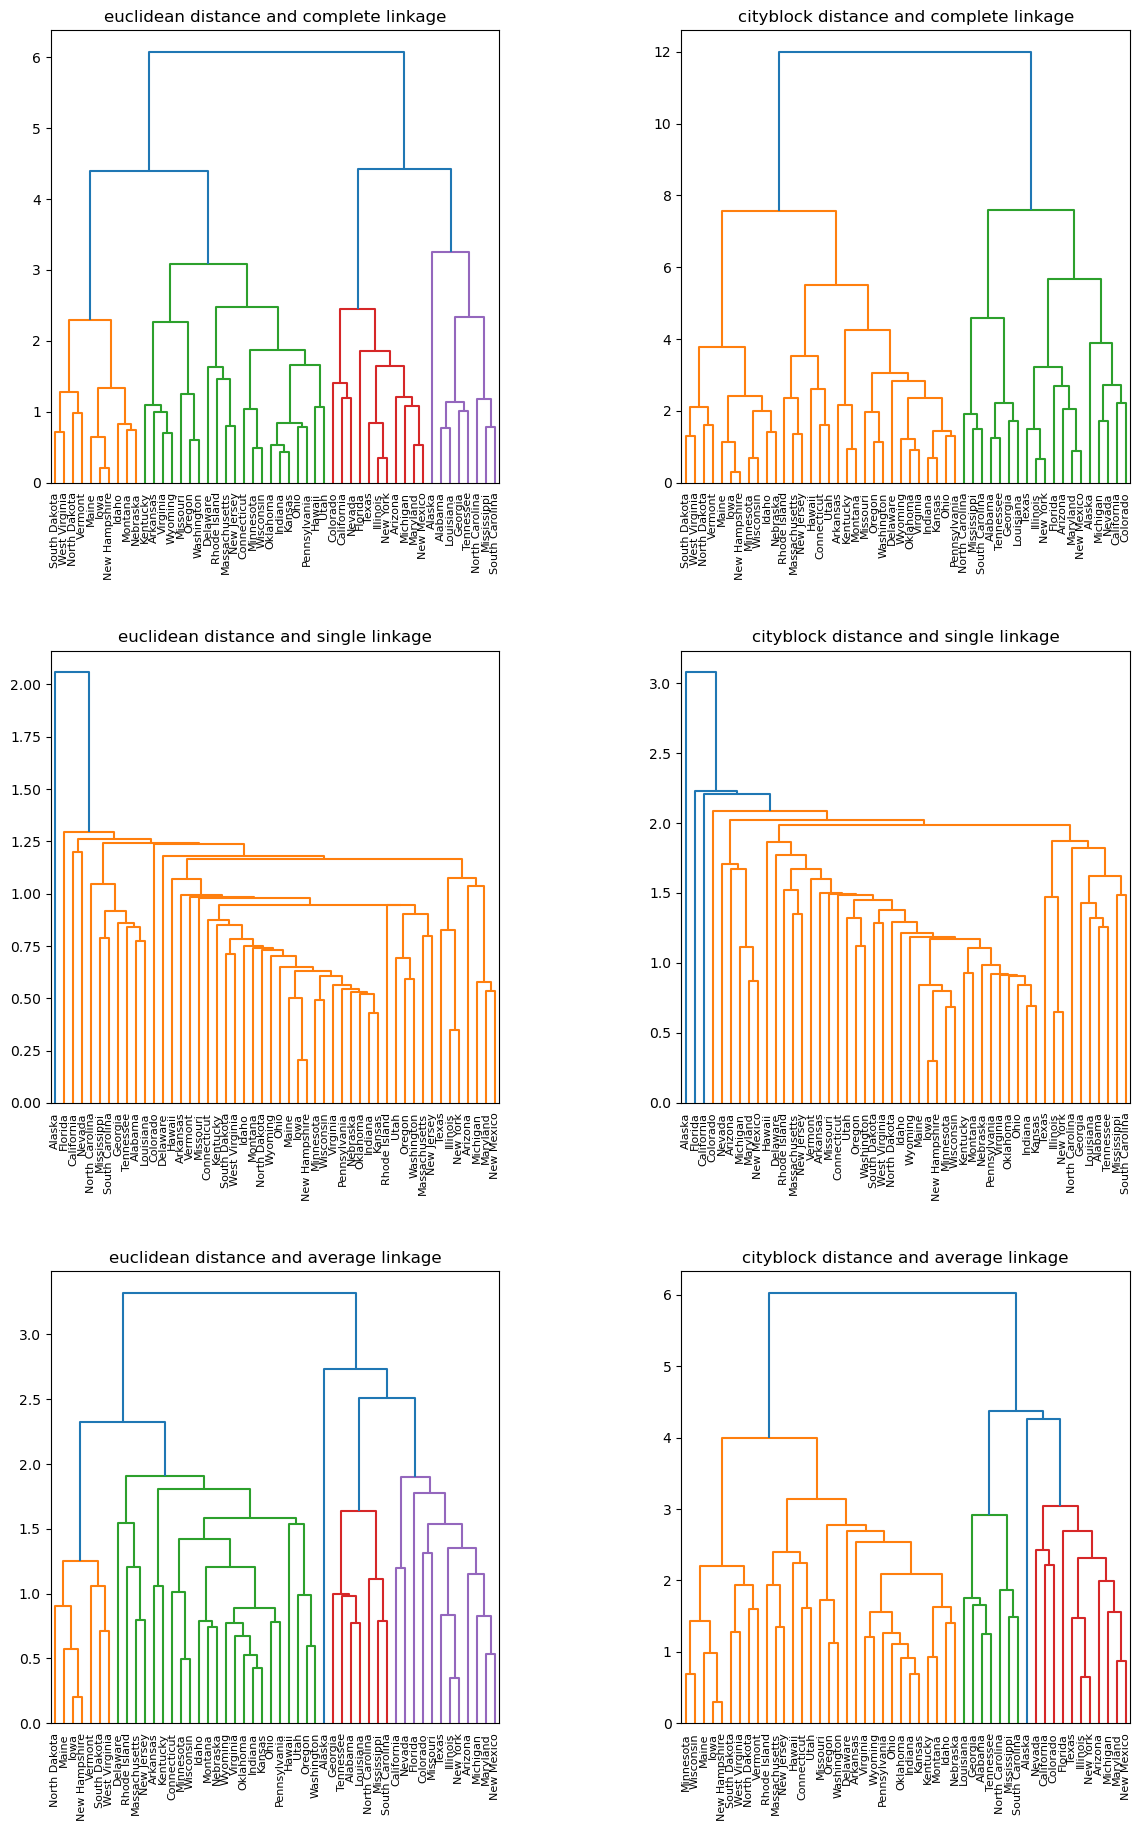

In [37]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(14, 20))
fig.tight_layout(pad=10.0)

metrics = ["euclidean", "cityblock"]
methods = ["complete", "single", "average"]

for i, method in enumerate(methods):
    for j, metric in enumerate(metrics):
        hdata = linkage(X, method=method, metric=metric)
        dendrogram(hdata, labels=X.index, ax=ax[i, j])
        ax[i, j].set_title(f"{metric} distance and {method} linkage")
plt.show()